Real inital desity n_i = 0.0123

Elapsed time 99.222589


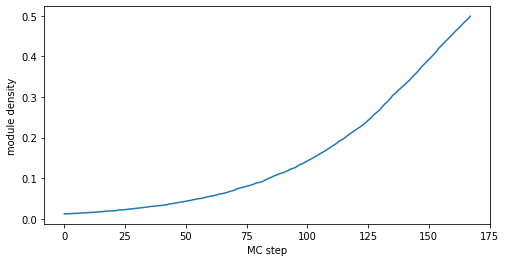

In [14]:
"""
Evaluation of simple proximity dynamics model by counting method.


(i) Model the network dynamics of solar panel installation
    by assuming panel proximity as the main determining variable.
(ii) Evaluate the early diffusion by counting solar panels in surrounding circle areas (radius r)
    For each new panel at time t-1, the number of new panels within A_r at time t (t+1, ...) is calculated

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 300000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

# save densities for visualizing global diffusion
densities = []

#----------------
# run simulation
#----------------
n_steps = 500 # MC steps

tol = 1e-3
period = 10 # measured in MC steps

# determine radii and intervals of interest
radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
intervals = np.array([1, 2, 3, 4], dtype='int8') # in periods

# indices of locs which change from state 
# False to True in a given period
new_panels = np.array([], dtype='int32')
last_new_panels = np.array([], dtype='int32')
new_panels_history = []


results = []
results_scaled = []

countP = 0
tStart = time()

for step in range(n_steps):
    
    countP += 1
    current_new_panels = mc_step(locs, state)
    new_panels = np.concatenate((new_panels, current_new_panels), axis=None)
    
    n = density(state)
    if n > 0.5:
        break
    densities.append(n)
    
    if countP >= period:
        # initialize tables for saving data
        panel_count_table = np.zeros((radii.size, intervals.size))
        panel_count_table_scaled = np.zeros((radii.size, intervals.size))
        
        # bool array for vectorized computation
        loc_is_new_panel = np.zeros(N, dtype='bool')
        loc_is_new_panel[new_panels] = True
        
        # fill panel count tables
        # for each last new panel
        # calculate relative nb of new panels within A_r        
        for k, radius in enumerate(radii):
            for j, timestamp in enumerate(intervals):
                if timestamp > len(new_panels_history): continue
    
                last_new_panels = new_panels_history[-timestamp]
                    
                # for vectorized computaion
                loc_is_last_new_panel = np.zeros(N, dtype='bool')
                loc_is_last_new_panel[last_new_panels] = True

                neighbourhood = all_dist < radius
                helper = np.tile(loc_is_new_panel, (N, 1))
                neighbourhood_panels = np.logical_and(helper, neighbourhood)

                n_neighbours = np.sum(neighbourhood, axis=1)[loc_is_last_new_panel]
                n_panels = np.sum(neighbourhood_panels, axis=1)[loc_is_last_new_panel]
                n_panels_rel = n_panels / n_neighbours
                avg_n_panels_rel = np.sum(n_panels_rel) / n_panels_rel.size
                
                panel_count_table[k][j] = avg_n_panels_rel
                panel_count_table_scaled[k][j] = avg_n_panels_rel / new_panels.size
        
        results.append(panel_count_table)
        results_scaled.append(panel_count_table_scaled)
        new_panels_history.append(new_panels)
        new_panels = np.array([], dtype='int32')
        countP = 0
    # END IF
    


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

df = pd.DataFrame()

In [15]:
print("Avg relative new panels in area A_r/r0 after xxx Periods")

mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results)):
    mean += results[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)

Avg relative new panels in area A_r/r0 after xxx Periods

r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	3.374e-02 	3.358e-02 	3.318e-02 	3.285e-02 	
0.87 |	3.415e-02 	3.423e-02 	3.463e-02 	3.372e-02 	
1.74 |	3.455e-02 	3.442e-02 	3.438e-02 	3.371e-02 	
3.48 |	3.450e-02 	3.434e-02 	3.443e-02 	3.374e-02 	


In [16]:
print("Avg relative new panels in area A_r/r0 after xxx Periods normalized by the total count of new panels")

mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results_scaled)):
    mean += results_scaled[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)

Avg relative new panels in area A_r/r0 after xxx Periods normalized by the total count of new panels

r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	1.049e-04 	1.020e-04 	1.011e-04 	9.525e-05 	
0.87 |	1.066e-04 	1.058e-04 	1.079e-04 	9.949e-05 	
1.74 |	1.064e-04 	1.062e-04 	1.065e-04 	9.918e-05 	
3.48 |	1.063e-04 	1.061e-04 	1.059e-04 	9.788e-05 	
